## Gaussian Process Latent Variable Model

The [Gaussian Process Latent Variable Model](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Gaussian_process_latent_variable_models) (GPLVM) is a dimensionality reduction method that uses a Gaussian process to learn a low-dimensional representation of (potentially) high-dimensional data. In the typical setting of Gaussian process regression, where we are given inputs $X$ and outputs $y$, we choose a kernel and learn hyperparameters that best describe the mapping from $X$ to $y$. In the GPLVM, we are not given $X$: we are only given $y$. So we need to learn $X$ along with the kernel hyperparameters.

We do not do maximum likelihood inference on $X$. Instead, we set a Gaussian prior for $X$ and learn the mean and variance of the approximate (gaussian) posterior $q(X|y)$. In this notebook, we show how this can be done using the `pyro.contrib.gp` module. In particular we reproduce a result described in [2].

In [16]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
# assert pyro.__version__.startswith('1.5.0')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(1)

### Dataset

Here we simulate a dataset with two cell types, both going through cell cycle.

For gene $g$ in cell $c$, the expression is generated by: $$y_{cg} = A_c\sin{(t - \tau_g)}+\varepsilon$$ 

Different genes are at different phases at any given time ($\tau_g$). $A_c$ is the same for each cell type, but is generally different for different cell types. $\epsilon$ is a guassian noise.

In [2]:
import numpy as np
from numpy import pi

In [159]:
np.random.seed(0)

n_cells_per_type = [1000, 1000]
n_genes = 500

n_cells = sum(n_cells_per_type)
n_types = len(n_cells_per_type)

tau = np.random.uniform(0., 2 * pi, n_genes)
A = np.random.uniform(0.5, 1., [1, n_genes])
A = np.vstack([A, -A])

expr = np.zeros([n_cells, n_genes])
time_truth = np.zeros(n_cells)
label_truth = np.array(sum([[i] * v for i, v in enumerate(n_cells_per_type)], []))

n_cells_done = 0

for i, n in enumerate(n_cells_per_type):
    t = np.random.uniform(0., 2 * pi, n).reshape([-1, 1])
    expr[n_cells_done : n_cells_done + n, :] = A[[i], :] * np.sin(t - tau) + np.random.normal(0., 0.01, [n, n_genes])
    time_truth[n_cells_done : n_cells_done + n] = t.squeeze()
    n_cells_done += n

In [160]:
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.65519,0.686517,0.762485,0.875298,0.666754,0.962079,0.931159,0.524345,0.626821,0.723068,...,0.506086,0.661415,0.614784,0.753431,0.868427,0.548838,0.757461,0.969206,0.614323,0.838571
1,-0.65519,-0.686517,-0.762485,-0.875298,-0.666754,-0.962079,-0.931159,-0.524345,-0.626821,-0.723068,...,-0.506086,-0.661415,-0.614784,-0.753431,-0.868427,-0.548838,-0.757461,-0.969206,-0.614323,-0.838571


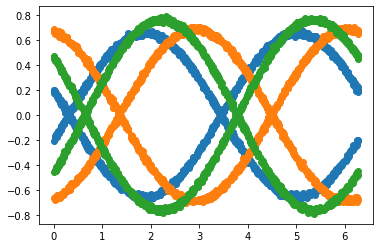

In [161]:
for g in range(3):
    plt.scatter(x=time_truth, y=expr[:, g])

### Modelling

First, we need to define the output tensor $y$.

In [162]:
data = torch.tensor(expr, dtype=torch.get_default_dtype())
# we need to transpose data to correct its shape
y = data.t()

In [163]:
# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), 2)
X_prior_mean[:, 0] = y.new_tensor(time_truth)
X_prior_mean[:, 1] = y.new_tensor(label_truth)

We will use a sparse version of Gaussian process inference to make training faster. Remember that we also need to define $X$ as a `Parameter` so that we can set a prior and guide (variational distribution) for it.

In [164]:
kernel = gp.kernels.Sum(gp.kernels.Periodic(input_dim=1, active_dims=[0], lengthscale=torch.ones(1)),
                        gp.kernels.RBF(input_dim=1, active_dims=[1], lengthscale=torch.ones(1)))

In [165]:
# kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))

# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())

# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 32)
# gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

We will use the [autoguide()](http://docs.pyro.ai/en/dev/contrib.gp.html#pyro.contrib.gp.parameterized.Parameterized.autoguide) method from the [Parameterized](http://docs.pyro.ai/en/dev/contrib.gp.html#module-pyro.contrib.gp.parameterized) class to set an auto Normal guide for $X$.

In [166]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

### Inference

As mentioned in the [Gaussian Processes tutorial](gp.ipynb), we can use the helper function [gp.util.train](http://docs.pyro.ai/en/dev/contrib.gp.html#pyro.contrib.gp.util.train) to train a Pyro GP module. By default, this helper function uses the Adam optimizer with a learning rate of `0.01`.

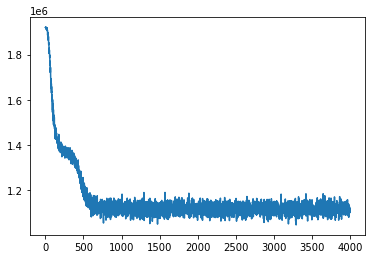

In [167]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

After inference, the mean and standard deviation of the approximated posterior $q(X) \sim p(X | y)$ will be stored in the parameters `X_loc` and `X_scale`. To get a sample from $q(X)$, we need to set the `mode` of `gplvm` to `"guide"`.

In [168]:
gplvm.mode = "guide"
X = gplvm.X  # draw a sample from the guide of the variable X

### Visualizing the result

Let’s see what we got by applying GPLVM to our dataset.

In [169]:
X = gplvm.X_loc.detach().numpy()

No handles with labels found to put in legend.


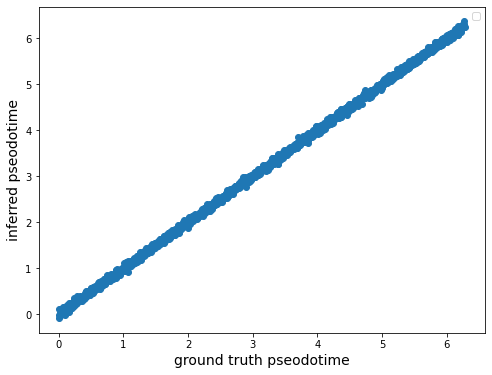

In [170]:
plt.figure(figsize=(8, 6))

plt.scatter(time_truth, X[:, 0])

plt.legend()
plt.xlabel("ground truth pseodotime", fontsize=14)
plt.ylabel("inferred pseodotime", fontsize=14)
plt.show()

No handles with labels found to put in legend.


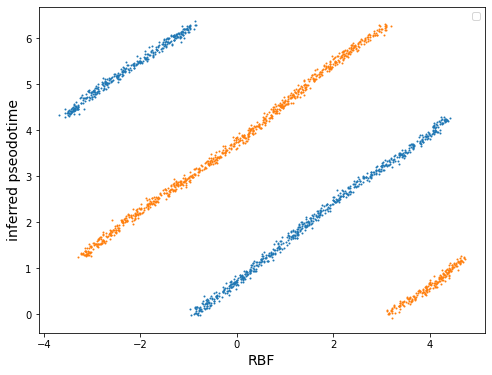

In [172]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = np.unique(label_truth)

for i in labels:
    X = gplvm.X_loc.detach().numpy()
    plt.scatter(X[label_truth == i, 1], X[label_truth == i, 0], s=1.)

plt.legend()
plt.xlabel("RBF", fontsize=14)
plt.ylabel("inferred pseodotime", fontsize=14)
plt.show()